Hello and welcome to my Space Titanic effort to predict which passengers are transported to an alternate dimension.
This is my analysis of the Kaggle dataset "spaceship-titanic"

NOTE FOR BEGINNERS: this notebook is merely the final notebook of my analytic work for this competition. I recommend, if you are a beginner, to approach your work similar to writing a draft in school. Begin by dumping your thoughts outs, and iterate by addings structure and removing junk. Don't let yourself get stuck trying to write eloquently, automating, cleaning, or engineering features, on your first go around.

In [1]:
#Importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
#Pulling in the data
submission = pd.read_csv("/kaggle/input/spaceship-titanic/sample_submission.csv")
passengers = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
testset_passengers = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

# Exploring the dataset as a whole

In [3]:
#Getting to know the data.
#Its rows vs columns
print("Shape: ",passengers.shape)
print("\n")
#Rows containing missing data by column
print("Nulls by Col: ","\n")
print(passengers.isnull().sum().sort_values())
print("\n")
#Total missing data points
print("Total Nulls: ",passengers.isnull().sum().sum())

Shape:  (8693, 14)


Nulls by Col:  

PassengerId       0
Transported       0
Age             179
RoomService     181
Destination     182
FoodCourt       183
Spa             183
VRDeck          188
Cabin           199
Name            200
HomePlanet      201
VIP             203
ShoppingMall    208
CryoSleep       217
dtype: int64


Total Nulls:  2324


Decent amount of rows, far from big data. 14 Columns is fairly rich and give some decent options, however Transported is the TARGET variable, and PassengerID will pointless due to its high cardinality.

In [4]:
#Columns and their datatype
#DataFrame 5 row sample
passengers.info()
passengers.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In previous interations, I explored and confirmed the following assumptions. But from what we can see from the sample, the attention grabbing features are that we can transform upfront.
* True/False columns that should be transformed into 1/0: CryoSleep, VIP, and Transported. 
* Cabin is a compound column that should be split into 3 separate columns: deck, num, and side.
* Name into 2 columns: first_name and last_name.
    * The primary reason for this is that we can create and easy new column from this by calculating family size aboard. 
    * Names are rarely useful in themselves due to their high cardinality.

This function is meant to apply the changes I identified in the previous text block. The reason it is a function is so I can reuse it for the TEST DATASET. This is the reason for the IF, the TEST DATASET does not contain the Transported column.

In [5]:
def earlyTransformations(dataset, is_training_set = True):
    #Will likely not be used - Dropping PassengerID
    if is_training_set:
        dataset[['Transported']] = dataset[['Transported']]*1
    
    #Transforming True/False to 1/0
    dataset[['CryoSleep','VIP']] = dataset[['CryoSleep','VIP']]*1
    
    #Splitting Cabin into deck/num/side columns
    #Dropping the Cabin column
    dataset[['deck','num','side']] = dataset['Cabin'].str.split(pat='/',expand=True)
    dataset = dataset.drop('Cabin',axis=1)
    dataset['num'] = dataset['num'].astype('float64')

    #Spliting Name into First Name and Last Name
    #Creating Family Size column from number of occurences of a passenger's last name
    dataset[['first_name', 'last_name']] = dataset['Name'].str.split(expand=True)
    dataset['family_size'] = dataset.groupby('last_name')['last_name'].transform('count')
    
    return dataset

Observing the changes made to the dataset

In [6]:
passengers = earlyTransformations(passengers)
passengers.info()
passengers.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Destination   8511 non-null   object 
 4   Age           8514 non-null   float64
 5   VIP           8490 non-null   object 
 6   RoomService   8512 non-null   float64
 7   FoodCourt     8510 non-null   float64
 8   ShoppingMall  8485 non-null   float64
 9   Spa           8510 non-null   float64
 10  VRDeck        8505 non-null   float64
 11  Name          8493 non-null   object 
 12  Transported   8693 non-null   int64  
 13  deck          8494 non-null   object 
 14  num           8494 non-null   float64
 15  side          8494 non-null   object 
 16  first_name    8493 non-null   object 
 17  last_name     8493 non-null   object 
 18  family_size   8493 non-null 

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,deck,num,side,first_name,last_name,family_size
0,0001_01,Europa,0,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,B,0.0,P,Maham,Ofracculy,1.0
1,0002_01,Earth,0,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,F,0.0,S,Juanna,Vines,4.0
2,0003_01,Europa,0,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,A,0.0,S,Altark,Susent,6.0
3,0003_02,Europa,0,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0,A,0.0,S,Solam,Susent,6.0
4,0004_01,Earth,0,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,F,1.0,S,Willy,Santantines,6.0


Checking the missing data per column. This is an extremely important even if it may appear to be redundant. Unfortunately, manipulating columns can often result in, missing data no longer registering as missing. Although, I am not entirely sure of the implications of missing data as not registering as missing, but it is best likely best avoided.

In [7]:
passengers.isnull().sum().sort_values()

PassengerId       0
Transported       0
Age             179
RoomService     181
Destination     182
FoodCourt       183
Spa             183
VRDeck          188
deck            199
num             199
side            199
last_name       200
Name            200
first_name      200
family_size     200
HomePlanet      201
VIP             203
ShoppingMall    208
CryoSleep       217
dtype: int64

# Exploratory Data Analysis

Exploring the data, starting with categorical features. Primarily, we are trying to get to know the data for key features or actionable engineering. For example most of the tranformations performed earlier in the notebook were discovered in a previous iteration during EDA.

# Exploring Categorical Features

Following code is an iterative function to output visualzations with 2 columns.
* LEFT column: show the distribution across the categories in each column. 
* RIGHT column: split of the column categories by TARGET value.

In [8]:
# Function to display distribution of Categorical columns
# Will display 2 visuals per column
# Will need to have columns chosen before hand.
def cat_cols_display(df):
    
    plt.figure(figsize=(15, 20))
    plt.subplots_adjust(hspace=0.5)
    plt.suptitle("Cat Feats", fontsize=18, y=0.95)

    cat_features = df.columns
    number_of_columns = len(cat_features)
    n=1
    
    # loop through the length of tickers and keep track of index
    for cat in cat_features:
        # add a new subplot iteratively
        ax = plt.subplot(number_of_columns, 2,n)

        # filter df and plot ticker on the new subplot axis
        sns.countplot(x=passengers[cat],
                     order = passengers[cat].value_counts().index)

        # chart formatting
        ax.set_title(cat.upper())
        #ax.get_legend().remove()
        ax.set_xlabel("")
        ax.bar_label(ax.containers[0])

        n +=1 #It

        ax2 = plt.subplot(number_of_columns, 2,n)
        sns.countplot(x=passengers[cat],
                  order = passengers[cat].value_counts().index,
                 hue =passengers['Transported'])

        n +=1

        # chart formatting
        ax2.set_title(cat.upper())
        #ax.get_legend().remove()
        ax2.set_xlabel("")
        ax2.bar_label(ax2.containers[0])

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Name',
       'deck', 'side', 'first_name', 'last_name'],
      dtype='object')


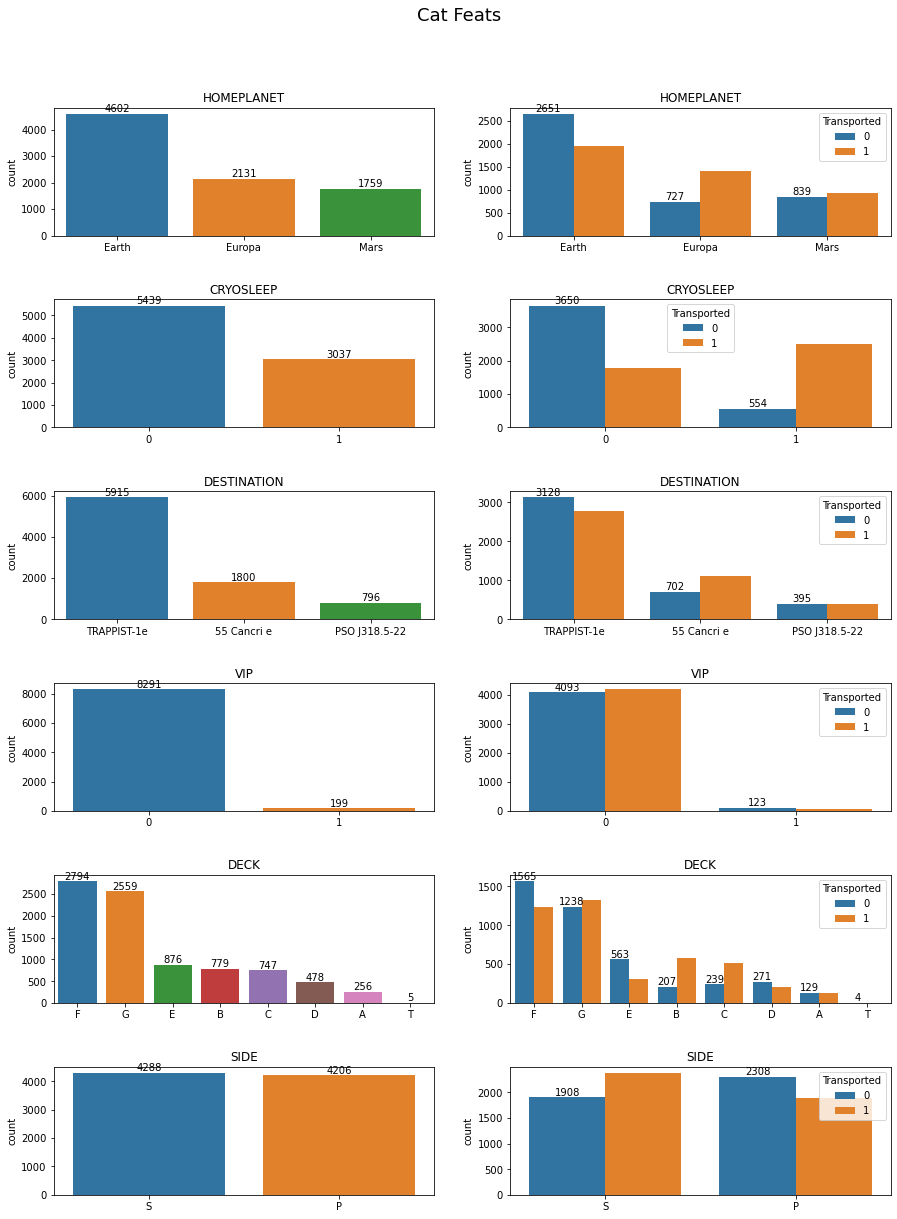

In [9]:
#Checking which columns are categorical
#Calling the function to display exploratory visualizations of categorical columns
print(passengers.select_dtypes(include='object').columns)
cat_cols_display(passengers[['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'deck', 'side']])

Notes on categorical visualizations
* There are a few columns with sizeable discrpencies. Discrepencies being imbalance in TARGET value in a category within a column.
* CyroSleep, HomePlanet, and deck having the largest discrepencies, so we should expect these to be the most important for predicting Transported.

# Exploring Continuous Features

Similar visualization function as the one for categorical features.
Iterative function to output visualzations with 2 columns.
* LEFT column: distribution of numbers contained in the feature, organized into bins. 
* RIGHT column: violin plot, split between non transported vs transported.

In [10]:
# Function to display distribution of Continuous columns
# Will display 2 visuals per column
# Will need to have columns chosen before hand.

def continuous_cols_display(df):
    
    plt.figure(figsize=(15, 40))
    plt.subplots_adjust(hspace=0.5)
    plt.suptitle("Continuous Feats", fontsize=18, y=0.95)

    continuous_features = df.columns
    subplot_row = len(continuous_features)
    n=1
    
    # loop through the length of tickers and keep track of index
    for feat in continuous_features:
        # add a new subplot iteratively
        ax = plt.subplot(subplot_row, 2,n)

        # filter df and plot ticker on the new subplot axis
        sns.histplot(data=passengers,
                     x=feat,
                    bins=50)

        # chart formatting
        ax.set_title(feat.upper())
        #ax.get_legend().remove()
        ax.set_xlabel("")
        n +=1 #Iterate subplot location

        ax2 = plt.subplot(subplot_row, 2,n)
        sns.violinplot(data=passengers, 
                       x="Transported", 
                       y=feat)

        n +=1 #Iterate subplot location

        # chart formatting
        ax2.set_title(feat.upper())
        ax2.set_xlabel("Transported")

Quick view of the descriptive statistics of the coninuous features.

In [11]:
passengers.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,num,family_size
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8693.000000,8494.000000,8493.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791,0.503624,600.367671,5.428117
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189,0.500016,511.867226,2.891901
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,167.250000,3.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,427.000000,5.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000,1.000000,999.000000,7.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,1.000000,1894.000000,18.000000


Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Transported', 'num', 'family_size'],
      dtype='object')


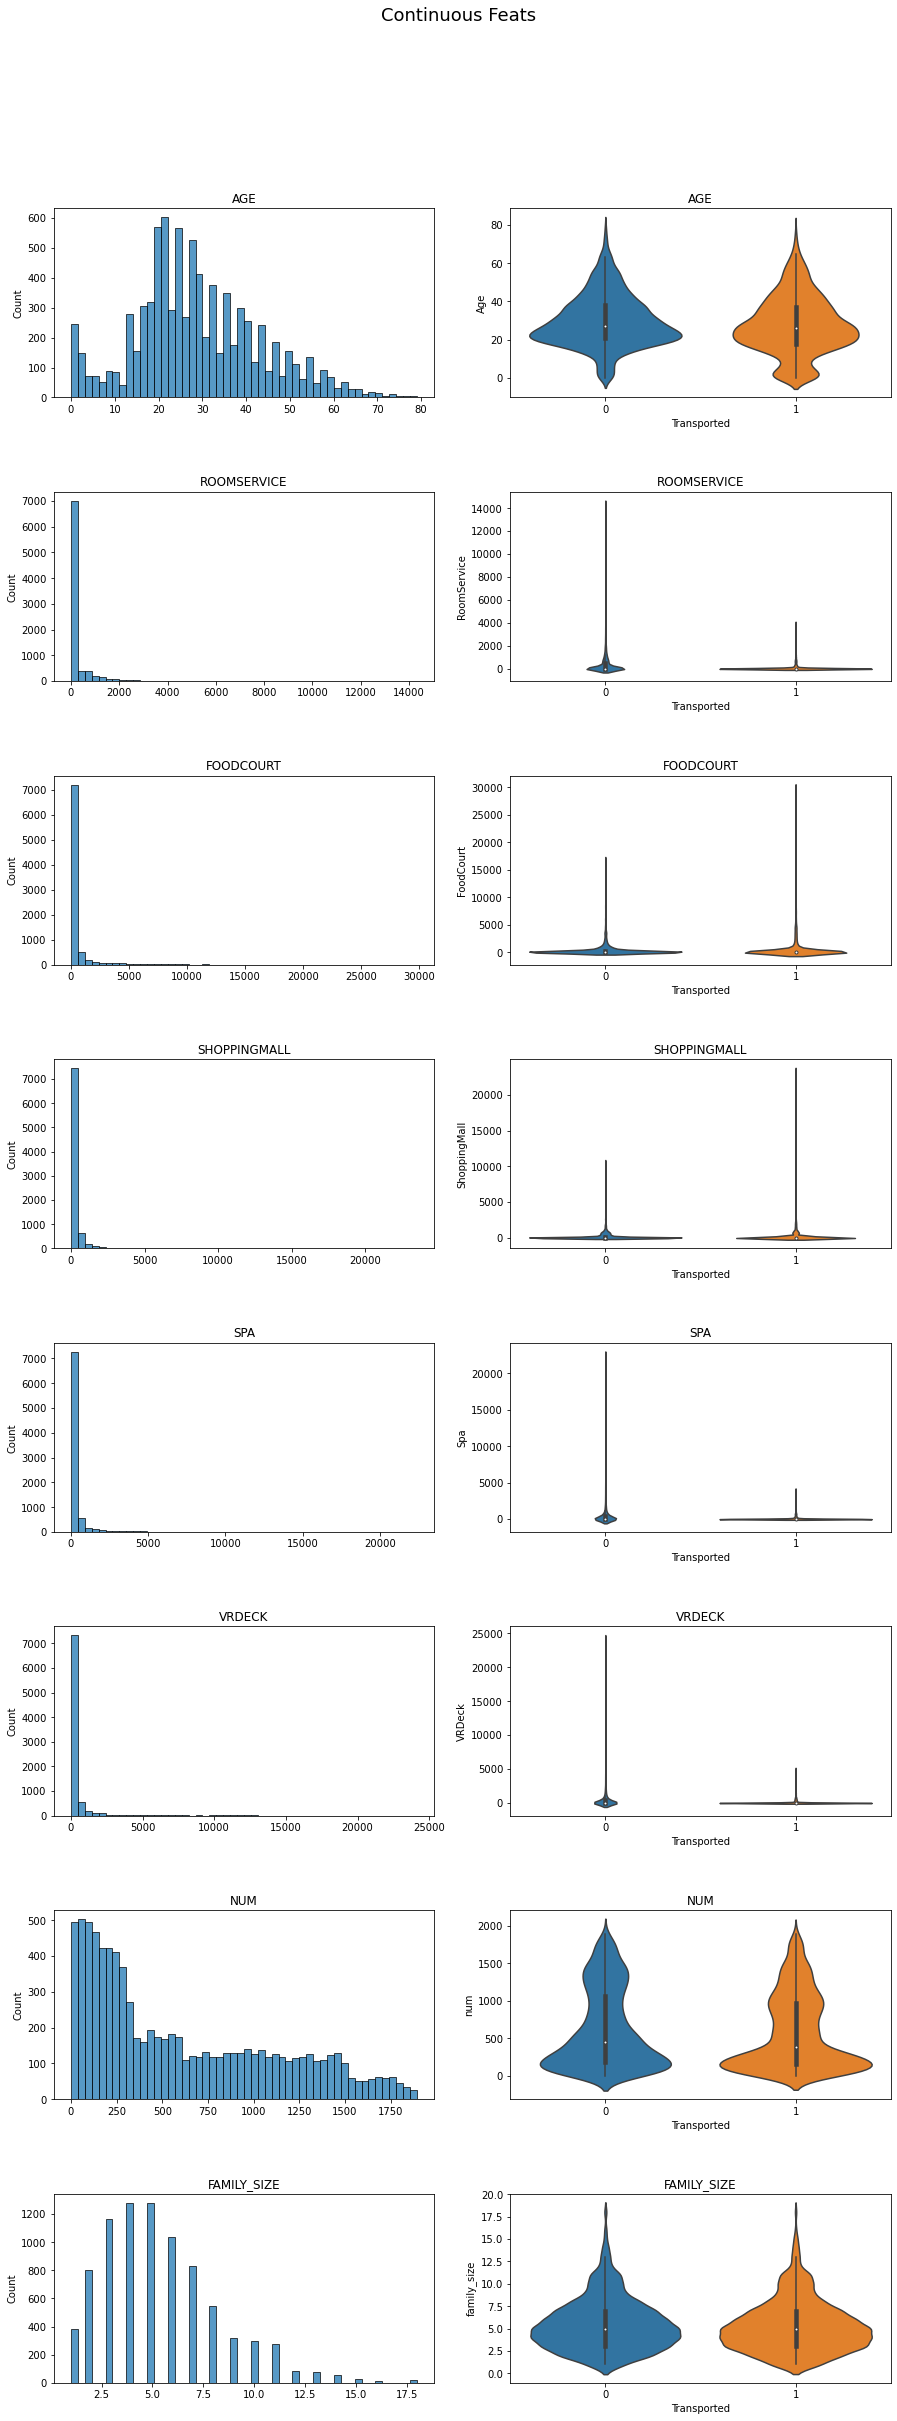

In [12]:
print(passengers.select_dtypes(exclude='object').columns)
df = passengers[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'num', 'family_size']]
continuous_cols_display(df)

Notes on categorical visualizations
* the spending features: RoomService, FoodCourt, ShoppingMall, Spa, and VRDeck have huge skews in their distributions between the target feature.
* Due to their similar nature (spending money), I will be adding 2 columns to combine these columns: Spending_Total and a binary Spent_Money.
* The other distributions have some discrepency but not nearly as much. 

In conclusion, the violin plots for the most part are almost mirror images, except for the spending features, which have some large discrepencies. Most notably: VRDeck, Spa, and RoomService.

In [13]:
corr_matrix=passengers.corr()
corr_matrix['Transported'].sort_values(ascending=False)

Transported     1.000000
FoodCourt       0.046566
ShoppingMall    0.010141
family_size    -0.033312
num            -0.045097
Age            -0.075026
VRDeck         -0.207075
Spa            -0.221131
RoomService    -0.244611
Name: Transported, dtype: float64

Correlation confirms the large discrepencies we saw in the violin plots, where VRDeck, Spa, and RoomService have the strongest relationship.

# Data Processing Pipeline

We are now ready to clean the data. I am doing this through a pipeline. Creating a pipeline is not necessary, but will allow the following code block to be used in future analyses.
Quick notes on whats happening in pipeline:
* There will be a split in inputs, continuous features and categorical features,leading to a combined output at the end of the pipeline.
* SimpleImputer is meant to replace missing values. Here I am using the median for continuous and catch-all 'missing' for categorical.
* StandardScaler to normalize the continuous features to have the same mean and standard deviation. Allowing for the analysis of continuous features on the same scale.
* OneHotEncoder generates a new column for each category in every categrical coloumn. Otherwise, the categorical columns are inefficient or impossible to analysis in most ML algorithms.

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

#Numeric Pipleine Steps
numerical_imputer = SimpleImputer(strategy='median')
numerical_scaler = StandardScaler()
    
#Categorical Pipleine Steps   
categorical_imputer = SimpleImputer(strategy='constant',
                                    fill_value='missing')
categorical_missing_encoder = OneHotEncoder(handle_unknown='ignore')

Within the pipeline I will be adding 2 new continous columns using the class below.
* spent_total is the sum of all money spending columns
* spent_money is binary, 1 for if spent_total is > 0 and 0 for if spent_total is <=0 

In [15]:
#Class to create 2 new columns step in pipeline

#Dynamically finding the columns needed in the 
col_names = 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'
RoomService_ix, FoodCourt_ix, ShoppingMall_ix, Spa_ix, VRDeck_ix = [
    passengers.columns.get_loc(c) for c in col_names] # get the column indices

from sklearn.base import BaseEstimator, TransformerMixin

class create_columns_for_spending(BaseEstimator, TransformerMixin):
    '''select specific columns of a given dataset'''
    def __init__(self):
        self
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        spent_total = X[:, RoomService_ix] + X[:, FoodCourt_ix] +  X[:, ShoppingMall_ix] + X[:, Spa_ix] +  X[:, VRDeck_ix]
        spent_money = np.where(spent_total > 0, 1, 0)       
        return np.c_[X, spent_total, spent_money]

#attr_adder = create_columns_for_spending()
#passengers_extra_attribs = attr_adder.transform(passengers.values)

Quick view of the info and head of the dataset before inset into the pipeline

In [16]:
passengers.info()
passengers.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Destination   8511 non-null   object 
 4   Age           8514 non-null   float64
 5   VIP           8490 non-null   object 
 6   RoomService   8512 non-null   float64
 7   FoodCourt     8510 non-null   float64
 8   ShoppingMall  8485 non-null   float64
 9   Spa           8510 non-null   float64
 10  VRDeck        8505 non-null   float64
 11  Name          8493 non-null   object 
 12  Transported   8693 non-null   int64  
 13  deck          8494 non-null   object 
 14  num           8494 non-null   float64
 15  side          8494 non-null   object 
 16  first_name    8493 non-null   object 
 17  last_name     8493 non-null   object 
 18  family_size   8493 non-null 

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,deck,num,side,first_name,last_name,family_size
0,0001_01,Europa,0,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,B,0.0,P,Maham,Ofracculy,1.0
1,0002_01,Earth,0,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,F,0.0,S,Juanna,Vines,4.0
2,0003_01,Europa,0,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,A,0.0,S,Altark,Susent,6.0
3,0003_02,Europa,0,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0,A,0.0,S,Solam,Susent,6.0
4,0004_01,Earth,0,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,F,1.0,S,Willy,Santantines,6.0


Identifying the continuous and categorical features. Creating continuous pipeline and categorical pipeline. Then combining these two pipelines into the full pipeline.

In [17]:
#Pipeline builds

#Identify and split the column names into numerical or categorical columns
numerical_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'
                      ,'num', 'family_size', 'CryoSleep', 'VIP']
categorical_features = ['HomePlanet', 'Destination', 'deck', 'side']


numerical_pipeline = Pipeline([
    ('num_imputer',numerical_imputer),
    ('scaler',numerical_scaler)
])

categorical_pipeline = Pipeline([
    ('cat_imputer',categorical_imputer),
    ('categorical_missing_encoder',categorical_missing_encoder)
])
     
full_pipeline = ColumnTransformer([
    ('num',numerical_pipeline,numerical_features),
    ('cat',categorical_pipeline,categorical_features)
])

In [18]:
passengers_labels = passengers['Transported'].copy()
passengers_prepared = full_pipeline.fit_transform(passengers)
passengers_prepared

array([[ 0.71194537, -0.33310466, -0.28102673, ...,  1.        ,
         0.        ,  0.        ],
       [-0.33403748, -0.16807343, -0.27538657, ...,  0.        ,
         1.        ,  0.        ],
       [ 2.03685698, -0.2680006 ,  1.95999765, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.1945731 , -0.33310466, -0.28102673, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.22382004, -0.33310466,  0.37636549, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.06060632, -0.14233462,  2.656871  , ...,  0.        ,
         1.        ,  0.        ]])

Output of the pipeline is a numpy array

# Cross Validation and Modeling

Now the fun part. We are ready to train and validate our models.

Function to run basic cv predictions, to get a baseline comparison of the models.

In [19]:
from sklearn.model_selection import cross_val_score

def CrossValidate_Model(model,X,y):
    # Multiply by -1 since sklearn calculates *negative* MAE
    scores = cross_val_score(model, X, y,
                                  cv=5,
                                  scoring='accuracy')

    print(model)
    print("Accuracy scores:\n", scores)
    print("Accuracy Average:\n", np.average(scores))
    print('\n')

In [20]:
from sklearn.model_selection import cross_val_score

def CrossValidate_Model(model,X,y):
    # Multiply by -1 since sklearn calculates *negative* MAE
    scores = cross_val_score(model, X, y,
                                  cv=5,
                                  scoring='accuracy')

    print(model)
    print("Accuracy scores:\n", scores)
    print("Accuracy Average:\n", np.average(scores))
    print('\n')

In [21]:
from sklearn.model_selection import GridSearchCV

def HyperParam_CV(model, X, y, param_grid):
        grid_search = GridSearchCV(model,
                                  param_grid,
                                  cv=5,
                                  scoring='accuracy',
                                  return_train_score=True)
        grid_search.fit(X, y)
        print(grid_search.best_params_)
        print(grid_search.best_score_)
        return grid_search.best_estimator_


Function to cross validate a given model by accuracy and to apply a Grid Search on a range of hyperparameters for a given model.
The function returns each distinct model with it's best performing combination of hyperparameters.

In [22]:
from sklearn.model_selection import GridSearchCV

def HyperParam_CV(model, X, y, param_grid):
        grid_search = GridSearchCV(model,
                                  param_grid,
                                  cv=5,
                                  scoring='accuracy',
                                  return_train_score=True)
        grid_search.fit(X, y)
        print(grid_search.best_params_)
        print(grid_search.best_score_)
        return grid_search.best_estimator_


Evaluating 3 classification models, as well as number of hyperparameters with various potential settings. Here I am running a basic cross validation before running the CV with hyperparameter optimization.

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

dtc = DecisionTreeClassifier(random_state=0)
dtc_param_grid = [{
    'min_samples_split': [1,2,5],
    'max_features': ['auto','sqrt']
}]

rfc = RandomForestClassifier(random_state=0)
rfc_param_grid = [{
    'n_estimators': [100,50,200],
    'max_features': [None,'auto','sqrt']
}]

xgb = XGBClassifier()
xgb_param_grid = [{
    "learning_rate":[0.3, 0.1, 0.03],
    "n_estimators":[100,50,200]
}]

models = [dtc,
          rfc,
          xgb]

param_grids = [dtc_param_grid, 
               rfc_param_grid, 
               xgb_param_grid]

for model in models:
    CrossValidate_Model(model,passengers_prepared,passengers_labels)

DecisionTreeClassifier(random_state=0)
Accuracy scores:
 [0.67740081 0.69695227 0.73145486 0.77445339 0.72209436]
Accuracy Average:
 0.7204711383273193


RandomForestClassifier(random_state=0)
Accuracy scores:
 [0.75273145 0.76250719 0.80966072 0.82163406 0.79516686]
Accuracy Average:
 0.7883400576101895


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None,
   

The RandomForestClassifier has the best average accuracy across the 5 folds in cross validation

In [24]:
dtc_final_model = HyperParam_CV(models[0], passengers_prepared, passengers_labels, param_grids[0])    

{'max_features': 'auto', 'min_samples_split': 10}
0.7205814486719415


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 942, in fit
    X_idx_sorted=X_idx_sorted,
  File "/opt/conda/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 254, in fit
    % self.min_samples_split
ValueError: min_samples_split must be an integer greater than 1 or a float i

{'max_features': None, 'min_samples_split': 10}

0.7302487243505287

In [25]:
rfc_final_model = HyperParam_CV(models[1], passengers_prepared, passengers_labels, param_grids[1])  

{'max_features': 'auto', 'n_estimators': 200}
0.7886846864492973


{'bootstrap': True, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}

0.797657476784867

In [26]:
xgb_final_model = HyperParam_CV(models[2], passengers_prepared, passengers_labels, param_grids[2])    

{'learning_rate': 0.1, 'n_estimators': 50}
0.7817833748348157


{'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.75}

0.795700014094843

# LazyPredict

When in Rome do as the Roman, well when Kaggling do as the Kagglers. Meaning do anything, no matter how impractical within data science's standard and norms, as long as it improves your overall score. On a more serious note, there's a lot of buzz around AutoML. After looking into its implementation with Python, I was pleasantly surprised to learn its actually a lot easier than I expected. Below is me using the library LazyPredict, which is an AutoML library. In this case I am use LazyPredict to only evaluate models a far wider range of model than I am proficient in.

In [27]:
pip install lazypredict

Note: you may need to restart the kernel to use updated packages.


Unfortunately, LazyPredict doesn't play well with CrossValidation, so I performed the standard train test split, but running the model is a cakewalk afterwards.

In [28]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(passengers_prepared, 
                                                    passengers_labels, 
                                                    test_size=.33, 
                                                    random_state=42)

clf = LazyClassifier(predictions=True)
lazy_models, lazy_predictions = clf.fit(X_train, X_test, y_train, y_test)

lazy_models


100%|██████████| 29/29 [00:20<00:00,  1.41it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.81,0.81,0.81,0.81,0.29
RandomForestClassifier,0.80,0.80,0.80,0.80,1.02
XGBClassifier,0.79,0.79,0.79,0.79,1.02
ExtraTreesClassifier,0.79,0.79,0.79,0.79,0.94
NuSVC,0.79,0.79,0.79,0.79,2.98
SVC,0.78,0.78,0.78,0.78,2.49
LogisticRegression,0.78,0.78,0.78,0.78,0.09
AdaBoostClassifier,0.78,0.78,0.78,0.78,0.45
BaggingClassifier,0.78,0.78,0.78,0.78,0.32


In [29]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(random_state=0)

lgbm_param_grid = [{
    "learning_rate":[0.3, 0.1, 0.03],
    "n_estimators":[100,50,200]
}]

lgbm_final_model = HyperParam_CV(lgbm, passengers_prepared, passengers_labels, lgbm_param_grid)    

{'learning_rate': 0.03, 'n_estimators': 100}
0.7883417781074662


# End of training
# Time to catch up the test set data predict on it

Now I need to bring my test set up to speed with my training set. Always satisfying after modulizing being able to do so in 2 line of code.

In [30]:
testset_passengers = earlyTransformations(testset_passengers, is_training_set=False)
testset_passengers_prepared = full_pipeline.fit_transform(testset_passengers)

Now that the test set is up to speed with no errors, were ready to predict and submit.

In [31]:
test_preds = rfc_final_model.predict(testset_passengers_prepared)
test_preds

array([0, 0, 1, ..., 1, 1, 0])

In [32]:
submission['Transported'] = test_preds.astype("bool")
submission.to_csv("submission.csv",index=False)
submission.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
